# **Ứng dụng của học máy trong cảnh báo nguy cơ mắc bệnh tim mạch vành**

<img src='242452624.jpg'>

## **1. Những mã nguồn sử dụng trong quá trình phát triển mô hình**

In [ ]:
# mã nguồn hỗ trợ nhập dữ liệu từ bộ nhớ
import pandas as pd
import numpy as np
# vẽ biểu đồ
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# utils
from collections import Counter
import sklearn
# xử lí dữ liệu
from sklearn.preprocessing import StandardScaler
# phân tách dữ liệu
from sklearn.model_selection import train_test_split
# phát triển mô hình
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## **2. Nhập và xử lí dữ liệu**

### **2.1. Nhập dữ liệu từ bộ nhớ**

In [ ]:
data = pd.read_csv('/content/framingham.csv')
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
data.isnull().sum() # Đếm số lượng dữ liệu thiếu theo từng cột

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

**Note:** Có thể thấy dữ liệu được công bố có nhiều dữ liệu trống (Null data), không thể sử lí đơn thuần bằng cách điền dữ liệu trung lập (0) vào phần còn thiếu.

In [ ]:
data.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000



### **2.2. Xử lí dữ liệu thiếu trong bộ dữ liệu gốc**

Nhóm quyết định dùng [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer) từ mã nguồn scikit-learn để xử lí những dữ liệu thiếu xót trong bộ dữ liệu gốc do NHLBI (Viện Tim, Phổi và Máu Quốc gia thuộc cơ quan chủ quản Bộ Y tế và Dịch vụ Nhân sinh Hoa Kỳ) công bố.

Phương pháp mà nhóm chọn khi phát triển các mô hình là dùng trung bình cộng của những dữ liệu còn lại cùng cột.

In [ ]:
from sklearn.impute import SimpleImputer
data_fix = data.copy()

mean_imputer = SimpleImputer(strategy='mean') 
data_fix.iloc[:,:] = mean_imputer.fit_transform(data_fix)
data_fix.isnull().sum()        # Kiểm tra số lượng dữ liệu chưa được điền


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [ ]:
print(data_fix)

      male   age  education  ...  heartRate     glucose  TenYearCHD
0      1.0  39.0        4.0  ...       80.0   77.000000         0.0
1      0.0  46.0        2.0  ...       95.0   76.000000         0.0
2      1.0  48.0        1.0  ...       75.0   70.000000         0.0
3      0.0  61.0        3.0  ...       65.0  103.000000         1.0
4      0.0  46.0        3.0  ...       85.0   85.000000         0.0
...    ...   ...        ...  ...        ...         ...         ...
4235   0.0  48.0        2.0  ...       84.0   86.000000         0.0
4236   0.0  44.0        1.0  ...       86.0   81.963655         0.0
4237   0.0  52.0        2.0  ...       80.0  107.000000         0.0
4238   1.0  40.0        3.0  ...       67.0   72.000000         0.0
4239   0.0  39.0        3.0  ...       85.0   80.000000         0.0

[4240 rows x 16 columns]


## **3. Chia dữ liệu thành tập huấn luyện và tập đánh giá**

In [ ]:
y = data_fix["TenYearCHD"]
X = data_fix.drop("TenYearCHD",axis=1)

**Note:** Dữ liệu nên được chuẩn hóa trước khi chia thành tập huấn luyện và tập đánh giá. Mã nguồn scikit-learn có công cụ [preprocessing.normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html?highlight=normalize#sklearn.preprocessing.normalize) để hỗ trợ việc này. Điều này được tiến sĩ Joaquin Sevilla và cộng sự khẳng định trong [nghiên cứu](https://www.researchgate.net/publication/3135573_Importance_of_input_data_normalization_for_the_application_of_neural_networks_to_complex_industrial_problems) của mình vào năm 1997.


In [ ]:
X = sklearn.preprocessing.normalize(X, norm='l2', axis=1, copy=True, return_norm=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [ ]:
print(X_train)

[[0.         0.01585077 0.02762432 ... 0.01322355 0.01497292 0.01477497]
 [0.70676074 0.00798155 0.00977463 ... 0.01146905 0.00890071 0.00727141]
 [0.70675286 0.01229577 0.00488726 ... 0.01584872 0.00960701 0.01199132]
 ...
 [0.70675966 0.00841298 0.01466192 ... 0.01016838 0.00988966 0.01033305]
 [0.         0.01738003 0.00690813 ... 0.01425536 0.01497736 0.01460559]
 [0.         0.00862866 0.00977458 ... 0.01103682 0.01059602 0.00931246]]


In [ ]:
print(y_test.unique())
counter = Counter(y_train)
print(counter[0], counter[1])

[0. 1.]
2520 448


In [ ]:
class_weight = {0: 1.,
                1: counter[0]/counter[1]}

Có thể thấy trong tập dữ liệu huấn luyện dữ liệu âm tính nhiều hơn khoảng gần 6 lần so với dữ liệu dương tính. Nếu không xử lí ở điểm này, mô hình sẽ có xu hướng cố gắng cho ra rất nhiều kết quả âm tính. Để mô phỏng quá trình học của con người, nhóm quyết định "ép buộc" mô hình phải tập trung nhiều hơn vào những mẫu dương tính.

`class_weight` dùng cho quá trình này.

## **4. Phát triển mô hình dự đoán**

**Note:** Ngoài độ chính xác tính theo phần trăm (accuracy trong bảo báo cáo) thì đối với bộ dữ liệu không cân bằng giữa số lượng mẫu dương tính và âm tính thì rất cần thiết phải có phương pháp tính điểm F1. Phương pháp này được tiến sĩ Marina Sokolova (University of Ottawa) và cộng sự giới thiệu lần đầu vào năm 2006 trong [bài nghiên cứu](https://www.researchgate.net/publication/225215404_Beyond_Accuracy_F-Score_and_ROC_A_Family_of_Discriminant_Measures_for_Performance_Evaluation) của mình.

# **4.1. Linear Regression**

In [ ]:
m1 = 'Logistic Regression'
lr = LogisticRegression(class_weight = class_weight)
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_f1 = sklearn.metrics.f1_score(y_test, lr_predict, average='macro')
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix:")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression: {:.5}".format(lr_acc_score*100),'\n')
print("F1 Score of Logistic Regression: {:.5}".format(lr_f1*100),'\n')
print(classification_report(y_test,lr_predict))


confussion matrix
[[753 323]
 [ 94 102]]


Accuracy of Logistic Regression: 67.217 

F1 Score of Logistic Regression: 55.583 

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78      1076
         1.0       0.24      0.52      0.33       196

    accuracy                           0.67      1272
   macro avg       0.56      0.61      0.56      1272
weighted avg       0.79      0.67      0.71      1272



## ***4.2. Random Forest Classfier*** 

In [ ]:
m2 = 'Random Forest Classfier'
rf = RandomForestClassifier(random_state=dep,max_depth=8, class_weight=class_weight)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_f1 = sklearn.metrics.f1_score(y_test, rf_predicted, average='macro')

rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix:")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest Classifier: {:.5}".format(rf_acc_score*100),'\n')
print("F1 Score of Random Forest Classifier: {:.5}".format(rf_f1*100),'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[943 133]
 [126  70]]


Accuracy of Random Forest Classifier: 79.638 

F1 Score of Random Forest Classifier: 61.507 

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1076
         1.0       0.34      0.36      0.35       196

    accuracy                           0.80      1272
   macro avg       0.61      0.62      0.62      1272
weighted avg       0.80      0.80      0.80      1272



## ***4.3. Random Forest Classifier without class weight***

In [ ]:
m3 = 'Random Forest Classfier'
rf_ = RandomForestClassifier(random_state=dep,max_depth=8)
rf_.fit(X_train,y_train)
rf_predicted_ = rf_.predict(X_test)
rf_f1_ = sklearn.metrics.f1_score(y_test, rf_predicted_, average='macro')

rf_conf_matrix_ = confusion_matrix(y_test, rf_predicted)
rf_acc_score_ = accuracy_score(y_test, rf_predicted)
print("confussion matrix:")
print(rf_conf_matrix_)
print("\n")
print("Accuracy of Random Forest Classifier: {:.5}".format(rf_acc_score_*100),'\n')
print("F1 Score of Random Forest Classifier: {:.5}".format(rf_f1_*100),'\n')
print(classification_report(y_test,rf_predicted_))

confussion matrix:
[[943 133]
 [126  70]]


Accuracy of Random Forest Classifier: 79.638 

F1 Score of Random Forest Classifier: 50.173 

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      1076
         1.0       0.64      0.05      0.09       196

    accuracy                           0.85      1272
   macro avg       0.75      0.52      0.50      1272
weighted avg       0.82      0.85      0.79      1272



Có thể thấy nếu không có `class_weight` mô hình Random Forest (mô hình đã làm rất tốt trước đó) gặp rất nhiều khó khăn để dự đoán được những mẫu dương tính trong tập đánh giá, dẫn đến ảnh hưởng rất lớn đến điểm F1.

## **5. Sự quan trọng của những tác nhân gây bệnh đối với mô hình**

**Quan trọng:** Một mô hình tối ưu trong tương lai khi đề tài này được nghiên cứu chỉnh chu có thể gợi ý cho giới khoa học về những tác nhân nào ảnh hướng lớn đến nguy cơ mắc bệnh của bệnh nhân. Tận dụng khả năng tính toán của máy tính để cho ra những hướng đi mới đối với nghiên cứu trong y học.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


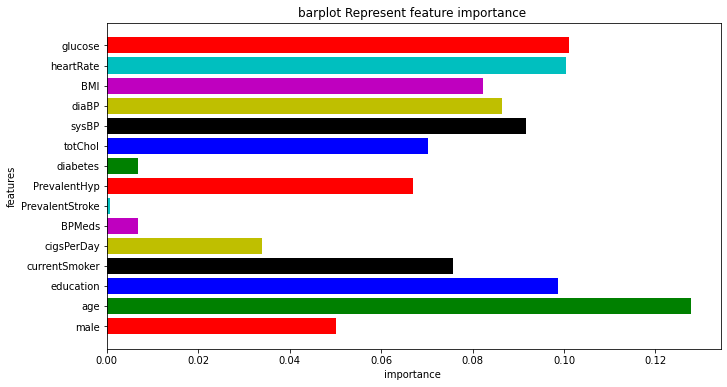

In [ ]:
imp_feature = pd.DataFrame({'Feature': ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'PrevalentStroke', 'PrevalentHyp',
       'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], 'Importance': rf.feature_importances_})
plt.figure(figsize=(11,6))
plt.title("barplot Represent feature importance ")
plt.xlabel("importance ")
plt.ylabel("features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')
plt.show()

## **5. ROC đánh giá mô hình**

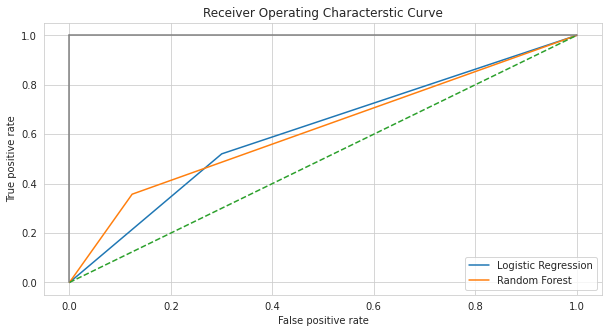

In [ ]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Receiver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()